# Nomenclature
###  
#### Isomer, Shape, Morphology: Nanoparticle's XYZ structural geometry (ICO, DIH, DECA, etc.)
#### Snapshot: single XYZ state of a nanoparticle taken from an MD trajectory
#### Configuration: local atomic environment within a cutoff from a central atom
#### Total database: set of local atomic environments and forces acting on the central atom for a set of morphologies, extracted form a set of DFT snapshots
#### Training database: subset of the total database selected according to some criteria
#### Test database: subset of the total database selected at random, not part of the training database
###    
### All distances are in Angstrom, all energies in eV, all forces in eV/A




# Imports

In [1]:
# Standard Imports
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
import sys

# import ASE
from ase.io import read
from ase import Atoms
# Import MFF
from mff import models
from mff.configurations import carve_confs
from mff import calculators
from mff.advanced_sampling import Sampling

%matplotlib notebook  
logging.basicConfig(level=logging.ERROR)  # Verbosity selection: INFO, WARNING or ERROR

No skbayes module found, rvm sampling cannot be used


# Extract the  total database

In [2]:
directory = 'data/Ni_19/' # Path to xyz
filename = directory + 'movie_all.xyz'


if filename[-3:] == "out":
    traj = read(filename, index=':', format='aims-output')
elif filename[-3:] == "xyz":
    traj = read(filename, index=slice(None), format='extxyz') # Get the ASE traj from xyz

In [5]:
# Extract configurations, forces, energies and elements from traj. Energies  may not be present
r_cut = 6.0  # Angstrom
n_data = 15000  # Number of configurations to extract to form the total database

if filename[-3:] == "out":
    elements, confs, forces, energies = carve_confs(
        traj, r_cut, n_data)
elif filename[-3:] == "xyz":
    elements, confs, forces, energies = carve_confs(
        traj, r_cut, n_data,
        forces_label='force', energy_label='energy')

# Count the atoms in each configuration
numatoms = [len(conf) for conf in confs]

print('\n'.join((
    'Number of atoms in a configuration:',
    '   maximum: {}'.format(np.max(numatoms)),
    '   minimum: {}'.format(np.min(numatoms)),
    '   average: {:.4}'.format(np.mean(numatoms))
)))

Number of atoms in a configuration:
   maximum: 18
   minimum: 12
   average: 17.55


### Check the histogram of distances to choose cutoff

Average number of atoms in each configuration is is 17.54716202270382 += 0.6762587157506914


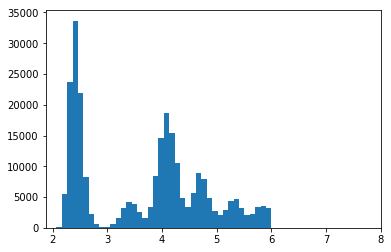

In [6]:
distances = []
M_mean = 0.
M_std = 0.
for c in confs:
    distances += np.linalg.norm(c[:, 0:3], axis=1).tolist()
    M_mean += c.shape[0]
    M_std += c.shape[0] ** 2

M_mean = M_mean / len(confs)
M_std = M_std / len(confs) - M_mean ** 2
print('Average number of atoms in each configuration is is {} += {}'.format(M_mean, M_std))
plt.figure()
plt.hist(distances, 40)
plt.xticks(np.arange(2.00, 9.0, step=1.0))
plt.show()

### Save the configurations, forces, energies

In [7]:
np.save('{}/confs_cut={:.2f}.npy'.format(directory, r_cut), confs)
np.save('{}/forces_cut={:.2f}.npy'.format(directory, r_cut), forces)
np.save('{}/energies_cut={:.2f}.npy'.format(directory, r_cut), energies)

# Gaussian Process with the MFF package

In [17]:
# GP Parameters
sigma_2b = 0.5  # Angstrom - typical value 0.2-0.6
sigma_3b = 0.8  # Angstrom - typical value 0.4-1.0
sigma_mb = 0.5  # Angstrom - This is used only to initialize the Sampling
noise = 0.01  # Number   - Typical values 0.01 - 0.0001
theta = r_cut/5.0 # Cutoff decay lengthscale in Angstrom - Typical value r_cut/5 - r_cut/10

ntr = 50       # Usually 2body kernel converges around 200, 3body and combined round 500-1000
ntest = 100

# Get training configurations and forces from file
confs = np.load(str(directory + 'confs_cut={:.2f}.npy'.format(r_cut)), allow_pickle=True)
forces = np.load(str(directory + 'forces_cut={:.2f}.npy'.format(r_cut)), allow_pickle=True)
energies = np.load(str(directory + 'energies_cut={:.2f}.npy'.format(r_cut)), allow_pickle=True)

numatoms = len(traj[0])
energies = np.repeat(energies, numatoms)   # To get an energy per each configuration instead of one per snapshot
elements = list(np.sort(list(set(confs[0][:,3:].flatten().tolist()))))

## Training and test set sampling

In [18]:
s = Sampling(confs, energies, forces, sigma_2b, sigma_3b, sigma_mb, noise, r_cut, theta) # Initialize Sampling module
s.train_test_split(confs=confs, energies= energies, forces = forces, ntest = ntest)      # Separate test set
tst_confs, tst_forces = s.x, s.y_force                                                   # Name test set

#### Random Sampling

In [19]:
random_index = s.random(ntrain = ntr, return_error = False) # sample at random for training set

#### Descriptor Space Sampling

In [22]:
grid_2b_index = s.grid('2b', nbins = 200, return_error = False) # sample using a distance-based histogram for training set
print("Number of training points selected: ",  len(grid_2b_index))

Number of training points selected:  75


In [21]:
# grid_3b_index = s.grid('3b', nbins = 20, return_error = False) # sample using a triplet-distance-based histogram for training set
# print("Number of training points selected: ",  len(grid_3b_index))

### Choose the kernel, initialize, and train the GP

In [23]:
m = models.TwoBodySingleSpeciesModel(element=elements, noise=noise, sigma=sigma_2b, theta=theta, r_cut=r_cut)
# m = models.ThreeBodySingleSpeciesModel(element=elements, noise=noise, sigma=sigma_3b, theta=r_cut/8.0, r_cut=r_cut)
# m = models.CombinedSingleSpeciesModel(elements=elements, noise=noise, sigma_2b=sigma_2b, sigma_3b=sigma_2b, theta_3b=r_cut/8.0, r_cut=r_cut, theta_2b=r_cut/8.0)
# m = models.ManyBodySingleSpeciesModel(element=elements, noise=noise, sigma=sigma_2b, theta=r_cut/8.0, r_cut=r_cut)

In [24]:
tr_confs, tr_forces = confs[grid_2b_index], forces[grid_2b_index]  # Decide what to use as a training set

In [25]:
m.fit(tr_confs, tr_forces)  # Fit the Gaussian Process

### Test the GP predicting forces on atoms

In [26]:
# Test the GP performance
print('Testing GP')

gp_forces= m.predict(tst_confs)   # Predict forces on test configurations
gp_error = gp_forces - tst_forces  # Calculate error

MAEC = np.mean(abs(gp_error))     # Mean average error on force components
MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))  # Mean average error on force vector
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))  # Standard deviation of the average error on force vector
MF = np.mean(np.linalg.norm(tst_forces, axis=1))  # Meean force value
RMSE = np.sqrt(np.mean((gp_error) ** 2))  #  Root mean square error on force

print('RMSE: {:.4}'.format(RMSE))
print('MAEC: {:.4}'.format(MAEC))

print('MAEF : {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

Testing GP
RMSE: 0.1315
MAEC: 0.09732
MAEF : 0.1965 +- 0.1150
Relative MAEF on forces: 0.3060 +- 0.1791


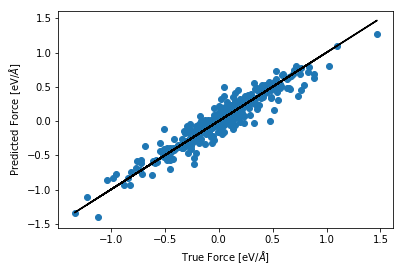

In [27]:
plt.figure()
plt.scatter(tst_forces, gp_forces)
plt.plot(tst_forces, tst_forces, 'k')
plt.xlabel('True Force [eV/$\AA$]')
plt.ylabel('Predicted Force [eV/$\AA$]')
plt.show()

#### Plot the 2-body potential to visualize what is the resulting force field

In [28]:
# Generate the potential
n_grid = 100
starting_distance = 1.5

potential_points = np.linspace(starting_distance, r_cut, n_grid)

gp_potential = np.zeros(n_grid)
gp_force = np.zeros((n_grid, 3))
gp_pot_uncertainty = np.zeros(n_grid)
for i in np.arange(n_grid):
    conf = np.asarray([[0.0, 0.0, 0.0, elements[0], elements[0]],[potential_points[i], 0.0, 0.0, elements[0], elements[0]]])
    gp_potential[i], gp_pot_uncertainty[i] = m.predict_energy(np.reshape(conf[1], (1, 1, 5)), return_std=True)
    gp_force[i] = m.predict(np.reshape(conf[1], (1, 1, 5)))

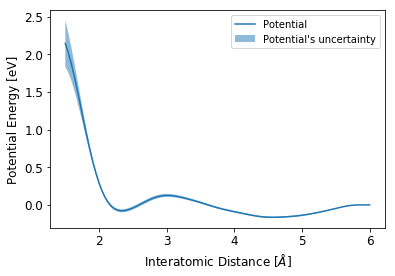

In [30]:
# Plot the potential
fs = 12
plt.figure()
plt.plot(potential_points, gp_potential, label = 'Potential')
plt.fill_between(potential_points, gp_potential - gp_pot_uncertainty, gp_potential + gp_pot_uncertainty,
                 alpha=0.5, label = "Potential's uncertainty")
plt.xlabel("Interatomic Distance [$\AA$]", fontsize = fs)
plt.ylabel("Potential Energy [eV]", fontsize = fs)
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.legend()
plt.show()

### Learning Curve

In [ ]:
ntrs = [20, 40, 80, 160, 320]
ntest = 50
print('N train: {}, N test: {}'.format(ntrs, ntest))
errors, stds = [], []

for ntr in ntrs:
    
    # Set training and testing configurations
    random_index = s.random(ntrain = ntr, return_error = False)
    tr_confs, tr_forces = confs[random_index], forces[random_index]
    print('Training GP')

    m.fit(tr_confs, tr_forces)

    # Test the GP performance
    print('Testing GP')

    gp_forces = m.predict(tst_confs)
    gp_error = gp_forces - tst_forces

    MAEC = np.mean(abs(gp_error))
    MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
    SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))
    RMSE = np.sqrt(np.mean((gp_error) ** 2))

    MF = np.mean(np.linalg.norm(tst_forces, axis=1))

    print('RMSE: {:.4}'.format(RMSE))
    print('MAEC: {:.4}'.format(MAEC))
    print('MAEF: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
    print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

    errors.append(MAEF)
    stds.append(SMAEF)

plt.figure()
plt.errorbar(ntrs, errors, yerr=stds, elinewidth=1.0, capsize=5)
plt.xlabel("Training Points")
plt.ylabel("Mean Absolute Error on Force [eV\ $\AA$]")
plt.show()

# Mapping

In [ ]:
mapping_ngrid_2b = 100 # Number of points used to build the spline
grid_start = 1.5 # angstrom
m.build_grid(grid_start, mapping_ngrid_2b)  # Map the Gaussian process to build a MFF

### Setup Calculator Module

In [ ]:
mff_calc = calculators.TwoBodySingleSpecies(r_cut, m.grid)  # Initialize calculator module

### Setup ASE Simulation

In [ ]:
# Additional ASE imports
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.velocitydistribution import Stationary
from ase.md.velocitydistribution import ZeroRotation
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase import units
from ase.io import extxyz

# Global Variables Definition
gamma = 0.001 #  For Langevin Dynamics
temp = 900 # K
dt = 1.0  # fs
steps = 10000
t = steps * dt * 10 ** (-3)  # time in ps
cell_length = 10.0 # Angstrom

In [ ]:
atoms = read(filename, index=0, format='extxyz')  # Read the input file and setup the initial geometry form the xyz file
atoms.set_positions(atoms.get_positions() - 0.5*np.array([cell_length, cell_length, cell_length]))  # Center atoms in the cell
atoms.set_cell([[cell_length, 0.0, 0.0], [0, cell_length, 0], [0, 0, cell_length]]) # Set the simulation cell if not present

In [ ]:
atoms.set_calculator(mff_calc) # Tell ASE how to get the forces ( AKA choose the potential)

In [ ]:
# Setup the momenta and velocities

dyn = VelocityVerlet(atoms, dt * units.fs)  # The dynamics will be a Verlet one
MaxwellBoltzmannDistribution(atoms, 2.0 * temp * units.kB)  # Initialize velocities according to MB distribution at double T because of equipartition theorem
ZeroRotation(atoms)  # Stop global rotation
Stationary(atoms)  # Stop global movement

In [ ]:
def printenergy(a=atoms):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    
def savexyz(a=atoms):
    this_traj = open(traj_filename, "a")
    extxyz.write_extxyz(this_traj, [atoms])

### Run Simulation

In [ ]:
traj_filename = "example.xyz"  # Output name
this_traj = open(traj_filename, "w")
dyn.attach(savexyz, interval=100)  # Save coordinates every interval steps
dyn.attach(printenergy, interval=100)  # Print informations every interval steps
dyn.run(steps)  # Have fun